## Exploratory Data Analysis an Time Series Forecasting: Tweets and Stock Prices

### 1. Libraries importation

In [ ]:
# install requirements
!pip3 install -r requirements.txt

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.auto import auto_arima
import pickle
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import tqdm
import warnings

warnings.filterwarnings("ignore")

In [133]:
# fix paths
DATA_PATH = 'data/'
MODEL_PATH = 'models/'
FIG_PATH = 'figs/'

### 2. Data importation

In [134]:
df = pd.read_csv(DATA_PATH+'data.csv')

### 3. Data cleaning

In [135]:
df.head()

,Date,Tweet,Stock Name,Open,High,Low,Close,Adj Close,Volume
0,2022-09-29,Mainstream media has done an amazing job at br...,TSLA,282.76001,283.649994,265.779999,268.209991,268.209991,77620600.0
1,2022-09-29,Tesla delivery estimates are at around 364k fr...,TSLA,282.76001,283.649994,265.779999,268.209991,268.209991,77620600.0
2,2022-09-29,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,282.76001,283.649994,265.779999,268.209991,268.209991,77620600.0
3,2022-09-29,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,282.76001,283.649994,265.779999,268.209991,268.209991,77620600.0
4,2022-09-29,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,282.76001,283.649994,265.779999,268.209991,268.209991,77620600.0


In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80793 entries, 0 to 80792
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        80793 non-null  object 
 1   Tweet       80793 non-null  object 
 2   Stock Name  80793 non-null  object 
 3   Open        63676 non-null  float64
 4   High        63676 non-null  float64
 5   Low         63676 non-null  float64
 6   Close       63676 non-null  float64
 7   Adj Close   63676 non-null  float64
 8   Volume      63676 non-null  float64
dtypes: float64(6), object(3)
memory usage: 5.5+ MB


In [137]:
df.dropna(inplace=True)

In [138]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,63676.000000,63676.000000,63676.000000,63676.000000,63676.000000,6.367600e+04
mean,229.638658,234.740393,223.959412,229.258614,228.772617,6.469818e+07
std,104.791403,107.574728,101.644990,104.610306,104.842858,4.459450e+07
min,11.100000,11.360000,10.930000,11.130000,10.906092,5.832000e+05
25%,141.737503,144.175621,139.179993,141.660004,140.040558,2.476100e+07
50%,245.199997,253.220001,239.603333,244.666672,244.666672,6.492690e+07
75%,310.000000,314.603333,301.666656,308.973328,308.730011,9.081030e+07
max,692.349976,700.989990,686.090027,691.690002,691.690002,2.726620e+08


In [139]:
# convert "Date" to datetime
df['Date'] = pd.to_datetime(df['Date'])
# sort by "Date"
df.sort_values(by='Date', inplace=True)
# reset index
df.reset_index(drop=True, inplace=True)

In [140]:
# check for duplicates
if df.duplicated().sum() == 0:
    print("No duplicates")
else:
    # delete duplicates
    print("{} duplicates found".format(df.duplicated().sum()))
    df.drop_duplicates(inplace=True)

19 duplicates found


### 4. Exploratory Data Analysis

In [141]:
# the number of unique values in "Stock Name"
s = df['Stock Name'].nunique()
print("Number of unique values in 'Stock Name':", s)

Number of unique values in 'Stock Name': 25


In [142]:
# return the unique values in "Stock Name"
stocks = df['Stock Name'].unique()

<Axes: ylabel='Stock Name'>

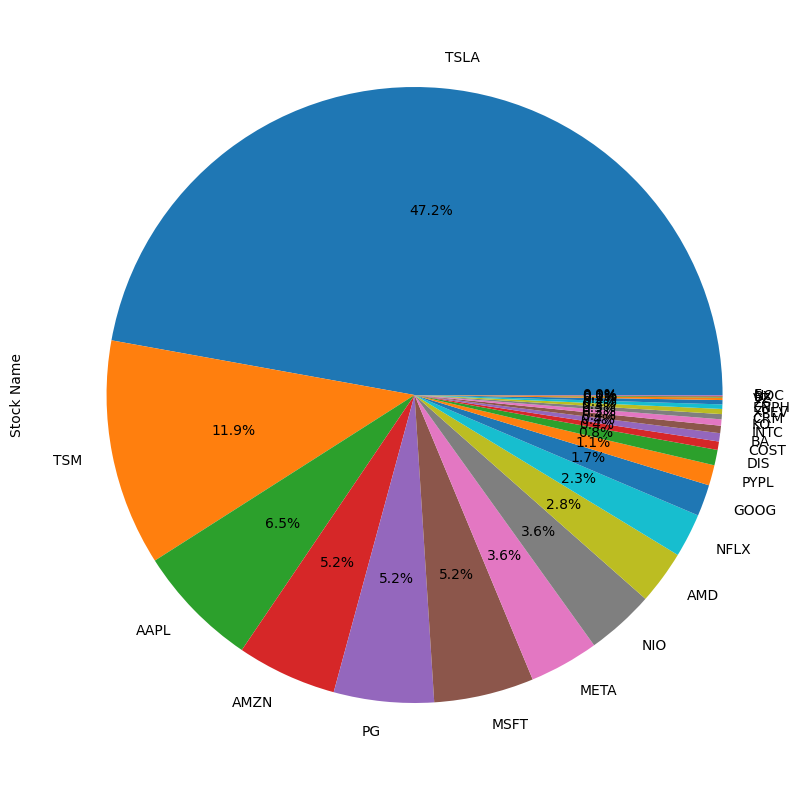

In [143]:
# group by "Stock Name" and plot pie chart for "Stock Name" ordered by percentage
df.groupby('Stock Name')['Stock Name'].count().sort_values(ascending=False).plot(kind='pie', figsize=(10,10), autopct='%1.1f%%')

In [144]:
# create a dictionary to store the dataframes for each stock
stock_dict = {}

# loop through each stock
for stock in df['Stock Name'].unique():
    # create a dataframe for each stock
    stock_dict[stock] = df[df['Stock Name'] == stock]
    # add a Count of tweets column and count the number of tweets for each day
    stock_dict[stock]['Count'] = stock_dict[stock].groupby('Date')['Date'].transform('count')

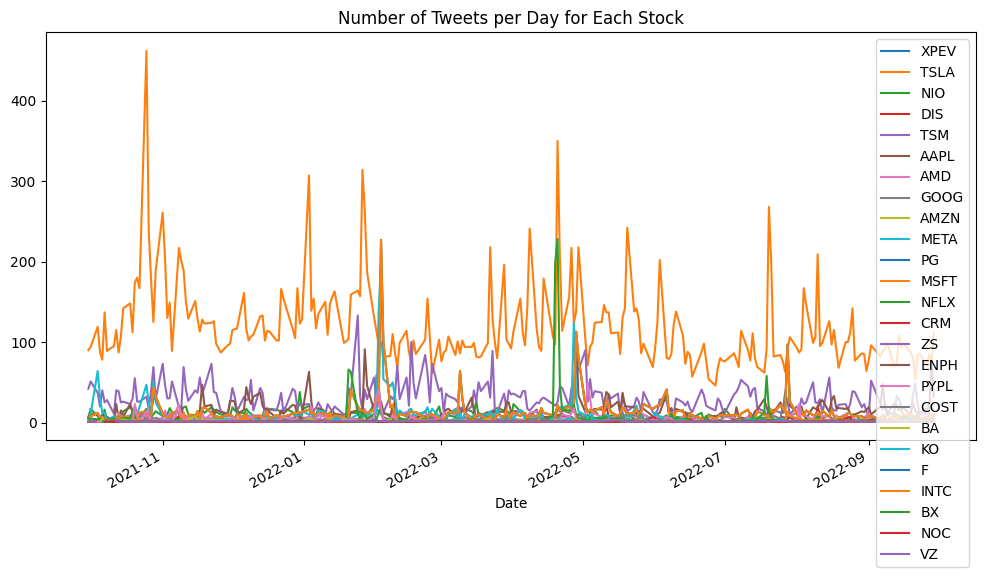

In [145]:
# plot the number of tweets per day for each stock in one figure
fig, ax = plt.subplots(figsize=(12, 6))
for stock in stock_dict:
    stock_dict[stock].plot(x='Date', y='Count', ax=ax, label=stock)

plt.title('Number of Tweets per Day for Each Stock')
plt.legend()
plt.show()

In [146]:
poc = df[df['Stock Name'] == "TSLA"]
poc.head()

,Date,Tweet,Stock Name,Open,High,Low,Close,Adj Close,Volume
1,2021-09-30,"$TSLA Little teaser, more pictures soon 😍🚀🙌🏻\n...",TSLA,260.333344,263.043335,258.333344,258.493347,258.493347,53868000.0
2,2021-09-30,UPDATE on Q3 Delivery Estimates:\n\n* FactSet ...,TSLA,260.333344,263.043335,258.333344,258.493347,258.493347,53868000.0
3,2021-09-30,"To set the record straight, my comments yester...",TSLA,260.333344,263.043335,258.333344,258.493347,258.493347,53868000.0
4,2021-09-30,wow. FSD Beta 10.1 is incredibly good. Not per...,TSLA,260.333344,263.043335,258.333344,258.493347,258.493347,53868000.0
5,2021-09-30,"♠️#LottoFriday♠️\n\nHigh risk, secure profits!...",TSLA,260.333344,263.043335,258.333344,258.493347,258.493347,53868000.0


In [147]:
# Group by 'Date' and aggregate the data
aggregated_poc = poc.groupby('Date').agg({
    'Tweet': lambda x: list(x),  # Convert tweets to a list for each day
    'Open': 'first',  # Assuming these values don't change for the same day
    'High': 'first',
    'Low': 'first',
    'Close': 'first',
    'Adj Close': 'first',
    'Volume': 'first'
}).reset_index()

# Now each row in aggregated_poc represents a unique day with a list of tweets from that day
# and other columns have consistent data for the day.

# You can print to check the new dataframe
aggregated_poc.head()

,Date,Tweet,Open,High,Low,Close,Adj Close,Volume
0,2021-09-30,"[$TSLA Little teaser, more pictures soon 😍🚀🙌🏻\...",260.333344,263.043335,258.333344,258.493347,258.493347,53868000.0
1,2021-10-01,[When I bought my 1st batch of $TSLA back in 2...,259.466675,260.260010,254.529999,258.406677,258.406677,51094200.0
2,2021-10-04,[Even @CNBC and @Lebeaucarnews trying to figur...,265.500000,268.989990,258.706665,260.510010,260.510010,91449900.0
3,2021-10-05,[UK Police making the switch to @Tesla Model 3...,261.600006,265.769989,258.066681,260.196655,260.196655,55297800.0
4,2021-10-06,"[Hey @Tesla wen #Doge?! Salty is ready, made m...",258.733337,262.220001,257.739990,260.916656,260.916656,43898400.0


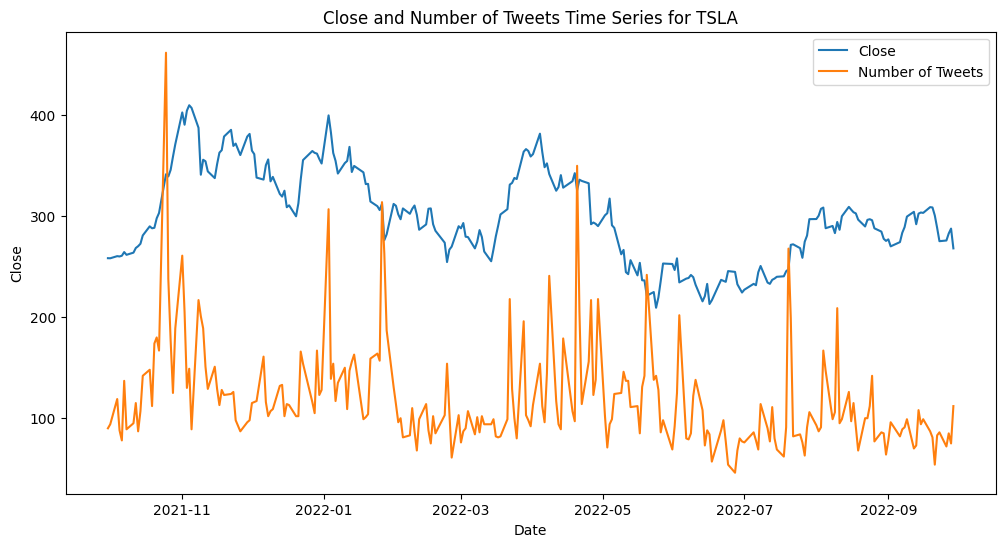

In [148]:
# plot the "close" and length of tweets time series for each day in 1 figure
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(aggregated_poc['Date'], aggregated_poc['Close'], label='Close')
ax.plot(aggregated_poc['Date'], aggregated_poc['Tweet'].apply(len), label='Number of Tweets')
ax.set_xlabel('Date')
ax.set_ylabel('Close')
ax.set_title('Close and Number of Tweets Time Series for TSLA')
ax.legend()
plt.show()

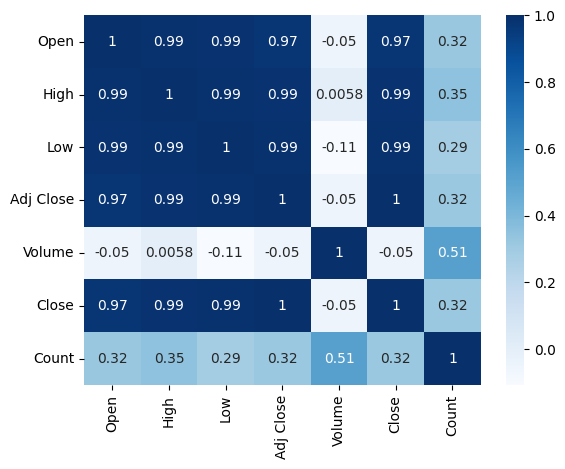

In [149]:
# add a column to store the number of tweets
aggregated_poc['Count'] = aggregated_poc['Tweet'].apply(len)

# plot the correlation between "Close" and "Count"
sns.heatmap(aggregated_poc[["Open","High","Low","Adj Close", "Volume", "Close", "Count"]].corr(), annot=True, cmap='Blues')
plt.show()

In [150]:
# drop the "Adj Close" column
aggregated_poc.drop(columns=['Adj Close'], inplace=True)

### 5. Natural Language Processing

#### tweets cleaning and polarity / subjectivity analysis

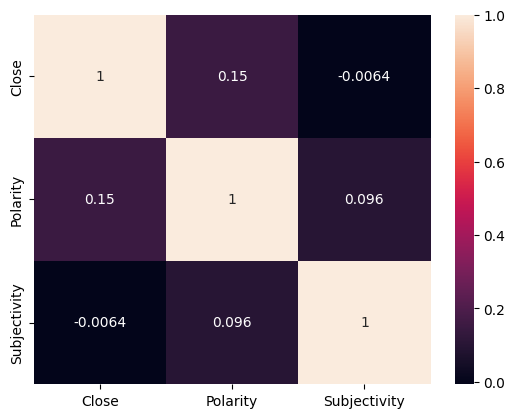

In [151]:
# analyse the sentiment of the tweets for each day
# add a column to store the sentiment of the tweets
aggregated_poc['Polarity'] = aggregated_poc['Tweet'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)
aggregated_poc['Subjectivity'] = aggregated_poc['Tweet'].apply(lambda x: TextBlob(' '.join(x)).sentiment.subjectivity)

# plot the correlation between "Close" and "Polarity" and "Subjectivity"
sns.heatmap(aggregated_poc[['Close', 'Polarity', 'Subjectivity']].corr(), annot=True)
plt.show()

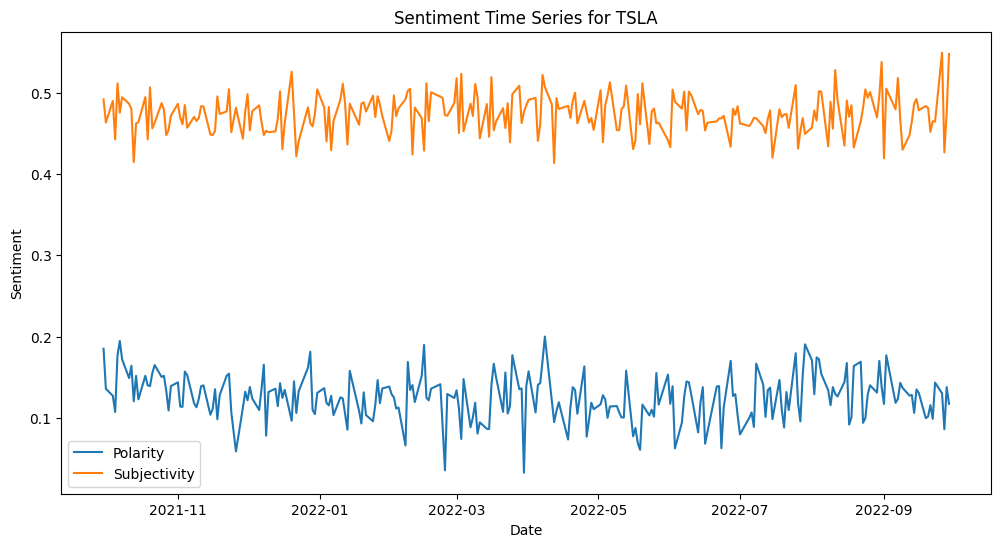

In [152]:
# plot the "Sentiment" time series
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(aggregated_poc['Date'], aggregated_poc['Polarity'], label='Polarity')
ax.plot(aggregated_poc['Date'], aggregated_poc['Subjectivity'], label='Subjectivity')
ax.set_xlabel('Date')
ax.set_ylabel('Sentiment')
ax.set_title('Sentiment Time Series for TSLA')
ax.legend()
plt.show()

In [153]:
# declare a function to join the strings in a list
def join_strings(l):
    return ' '.join(l)

# join the strings in the "Cleaned Tweets" column
aggregated_poc['Joined Tweets'] = aggregated_poc['Tweet'].apply(lambda x: join_strings(x))

#### TF-IDF analysis

In [154]:
# compute the TF-IDF score for each word in the tweets
vectorizer = TfidfVectorizer()

# fit the vectorizer to the tweets
tfidf_matrix = vectorizer.fit_transform(aggregated_poc['Joined Tweets'])

# convert the vectorizer vocabulary to a dataframe
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [155]:
# Add the maximum TF-IDF score for each document
aggregated_poc['max_tfidf'] = tfidf_df.max(axis=1)

# Add the mean TF-IDF score for each document
aggregated_poc['mean_tfidf'] = tfidf_df.mean(axis=1)

# Add the sum TF-IDF score for each document
aggregated_poc['sum_tfidf'] = tfidf_df.sum(axis=1)

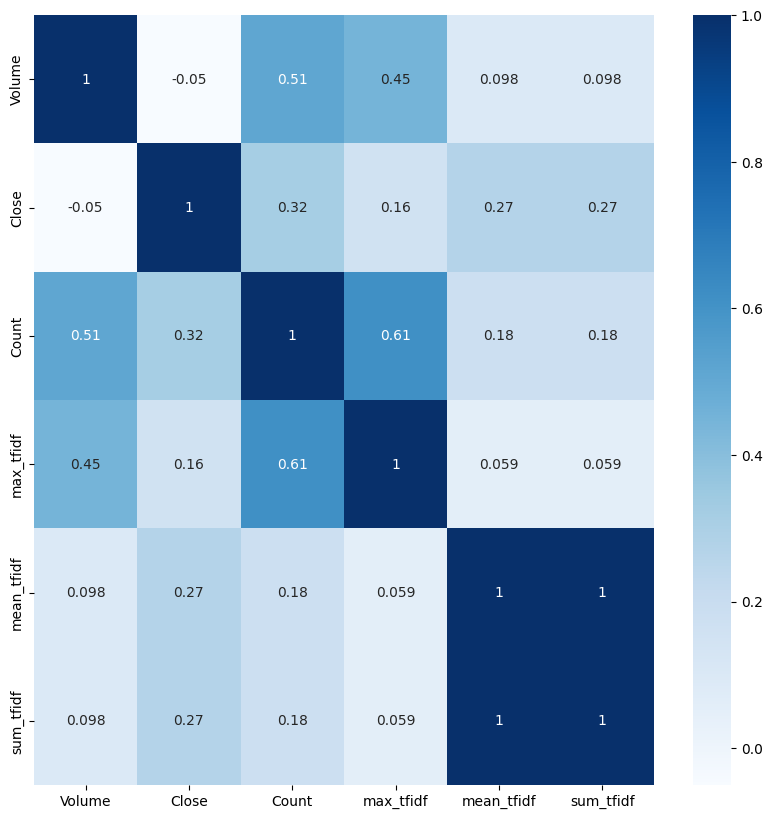

In [156]:
# plot the correlation matrix for the "Close" column with numerical columns
plt.figure(figsize=(10, 10))
sns.heatmap(aggregated_poc[["Volume", "Close","Count", "max_tfidf", "mean_tfidf", "sum_tfidf"]].corr(), annot=True, cmap='Blues')
plt.show()

In [157]:
# save the data
aggregated_poc.to_csv(DATA_PATH+"aggregated_poc.csv", index=False)

### 6. Time Series Forecasting

#### Stock prices analysis and visualization

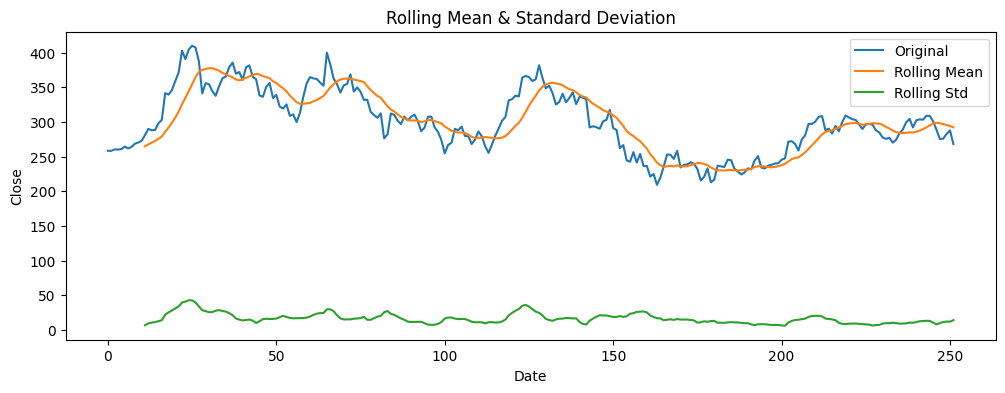

Results of Dickey-Fuller Test:
Test Statistic                  -2.188114
p-value                          0.210588
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


In [158]:
# study the statistical criteria of the time series before applying the ARIMAX model
# create a function to check the stationarity of the time series
def check_stationarity(y):
    # Determing rolling statistics
    rolmean = y.rolling(12).mean()
    rolstd = y.rolling(12).std()
    # Plot rolling statistics:
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(y, label='Original')
    ax.plot(rolmean, label='Rolling Mean')
    ax.plot(rolstd, label='Rolling Std')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close')
    ax.set_title('Rolling Mean & Standard Deviation')
    ax.legend()
    plt.show()
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

# check the stationarity of the "Close" time series
check_stationarity(aggregated_poc['Close'])

#### data normalization and standardization

In [159]:
# normalise every numerical column except "Date" and "Close"
scaler = MinMaxScaler()
aggregated_poc[['Volume', 'Count', 'max_tfidf', 'mean_tfidf', 'sum_tfidf',"Close"]] = scaler.fit_transform(
    aggregated_poc[['Volume', 'Count', 'max_tfidf', 'mean_tfidf', 'sum_tfidf',"Close"]])
# standardise every numerical column except "Date" and "Close"
scaler = StandardScaler()
aggregated_poc[['Volume', 'Open','Count', 'max_tfidf', 'mean_tfidf', 'sum_tfidf',"Close"]] = scaler.fit_transform(
    aggregated_poc[['Volume','Open', 'Count', 'max_tfidf', 'mean_tfidf', 'sum_tfidf', "Close"]])

In [160]:
# save the data
aggregated_poc.to_csv(DATA_PATH+"aggregated_normalized_poc.csv", index=False)

#### ACF and PACF analysis

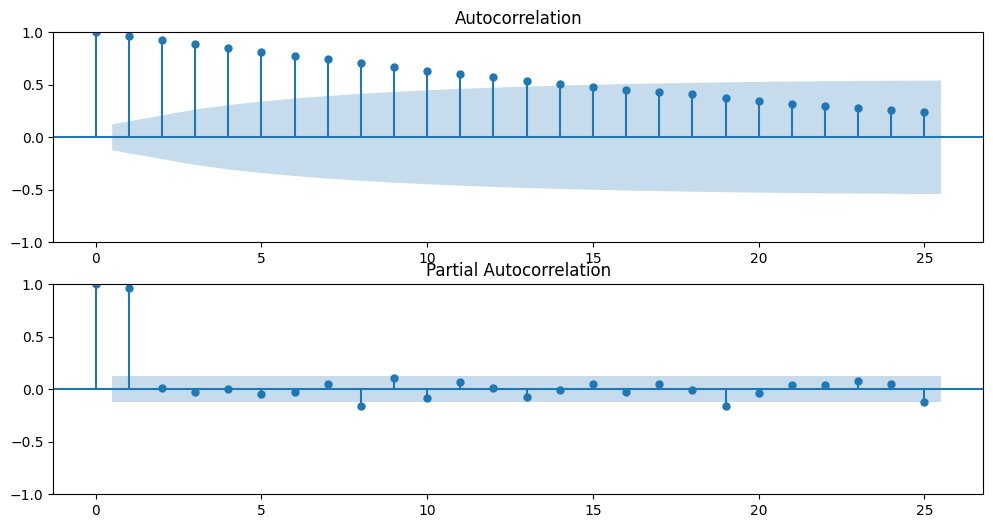

In [161]:
# plot the Autocorrelation and Partial Autocorrelation
fig, ax = plt.subplots(2, figsize=(12, 6))
plot_acf(aggregated_poc['Close'], ax=ax[0])
plot_pacf(aggregated_poc['Close'], ax=ax[1])
plt.show()

#### ARIMAX model fine tuning

In [162]:
# fit the ARIMA model
model = auto_arima(
    aggregated_poc['Close'],
    trace=True,
    suppress_warnings=True, 
    exogenous=aggregated_poc[['Volume',"Open", 'Count', 'max_tfidf', 'mean_tfidf', 'sum_tfidf']],
    stationary=False,
    seasonal=False,
    d=1,
    start_p=0,
    start_q=0,
    max_p=5,
    max_q=5,
    max_d=3,
    stepwise=False,
    max_order=None,
    error_action='ignore'
    )

p, d, q = model.order

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=58.944, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=60.847, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=62.845, Time=0.28 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=64.637, Time=0.71 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=65.877, Time=1.02 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=67.761, Time=1.46 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=60.847, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=62.803, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=64.795, Time=0.67 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=66.456, Time=1.12 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=65.296, Time=1.72 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=64.301, Time=2.57 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=62.843, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=64.843, Time=0.25 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=66.801, Time=0.84 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AI

#### save the model

In [163]:
# save the model
with open(MODEL_PATH+'arima_({},{},{}).pkl'.format(p,d,q), 'wb') as f:
    pickle.dump(model, f)

#### load the model

In [164]:
# load the model
# with open(MODEL_PATH+'arima_({},{},{}).pkl'.format(p,d,q), 'rb') as f:
#     model = pickle.load(f)

#### model evaluation

In [165]:
# split into train and test sets
X = aggregated_poc['Close'].values
exogenous = aggregated_poc[['Volume',"Open", 'Count', 'max_tfidf', 'mean_tfidf', 'sum_tfidf']].values
size = int(len(X) * 0.66)
trainX, testX = X[0:size], X[size:len(X)]
train_exogenous, test_exogenous = exogenous[0:size], exogenous[size:len(X)]
historyX = [x for x in trainX]
history_exogenous = [x for x in train_exogenous]
predictions = list()
# walk-forward validation
for t in tqdm.tqdm(range(len(testX)), desc='Predicting', unit='day', total=len(testX), ncols=100):
    model = ARIMA(endog=historyX, exog=pd.DataFrame(history_exogenous), order=(p, d, q))
    model_fit = model.fit()
    output = model_fit.forecast(exog=pd.DataFrame([test_exogenous[t]]))  # Need to wrap the exogenous variables into a DataFrame
    yhat = output.values[0]
    predictions.append(yhat)
    historyX.append(testX[t])
    history_exogenous.append(list(test_exogenous[t]))

Predicting: 100%|██████████████████████████████████████████████████| 86/86 [05:47<00:00,  4.05s/day]


In [166]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(testX, predictions))
r2 = r2_score(testX, predictions)
print('Test RMSE: %.3f' % rmse)
print('R2 score: %.3f' % r2)

Test RMSE: 0.195
R2 score: 0.905


#### forecast visualization

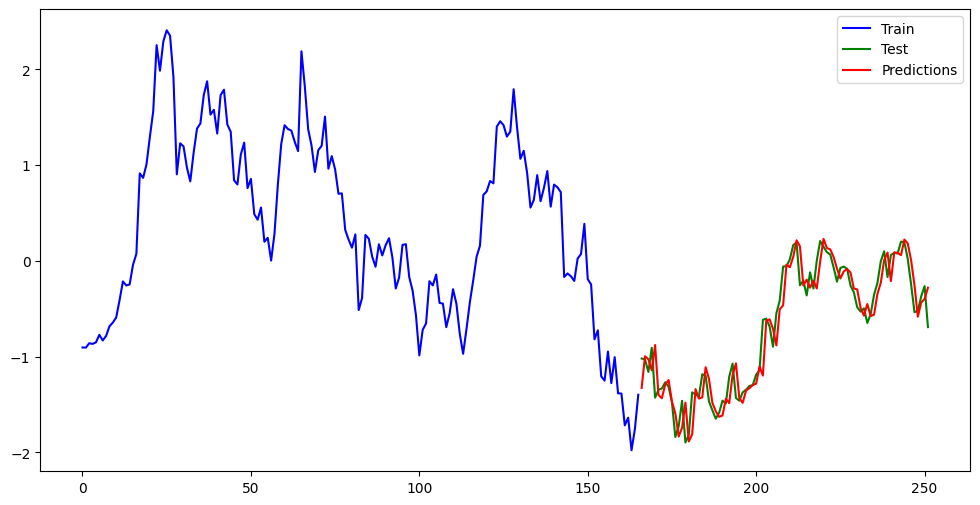

<Figure size 640x480 with 0 Axes>

In [167]:
# plot forecasts against actual outcomes
pyplot.figure(figsize=(12, 6))
pyplot.plot(trainX, color='blue')
pyplot.plot([None for i in trainX] + [x for x in testX], color='green')
pyplot.plot([None for i in trainX] + [x for x in predictions], color='red')
pyplot.legend(['Train', 'Test', 'Predictions'])
pyplot.show()
pyplot.savefig(FIG_PATH+'ARIMA({},{},{})_forecast.png'.format(p,d,q))

In [169]:
# save the packages used in  this notebook

pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
